# Gaussian Models

Gaussian models that are typically used to described extra-axonal diffusion. Briefly, we have:  
- Ball model: Isotropic Gaussian diffusion with diffusion coefficients $\lambda_{iso}$.
- Zeppelin Model: Axially symmetric Gaussian tensor, oriented along orientation $\mu$ with parallel and perpendicular diffusivity $\lambda_\parallel$ and $\lambda_\perp$.
- Restricted zeppeling model: Axially symmetric Gaussian tensor with time-dependent perpendicular diffusion to account for diffusion restricted in the extra-axonal space between axons. Instead of $\lambda_\perp$, this model has $\lambda_{inf}$ and characteristic coefficient $A$.

## Ball: G1
the ``Ball'' model *(Behrens et al. 2013)* models the totallity of all extra-axonal diffusion as a Tensor with isotropic diffusivity $\lambda_{\textrm{iso}}$ as

\begin{equation}
E_{\textrm{iso}}(b,\lambda_{\textrm{iso}})=\exp(-b\lambda_{\textrm{iso}}).
\end{equation}

In current models, the Ball is usually only used to describe the CSF and/or grey matter compartment of the tissue, where the isotropic diffusion assumption is reasonably valid*(Alexander et al. 2010, Jeurissen et al. 2014, Tariq et al. 2016)*.

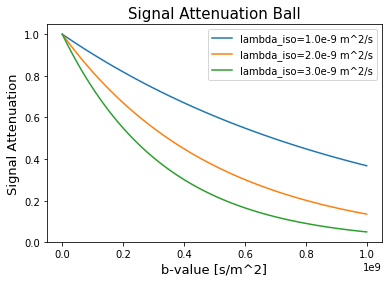

In [1]:
from dmipy.signal_models import gaussian_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

samples = 100
bvalues = np.linspace(0, 1e9, samples)
bvectors = np.tile([0, 0, 1], (samples, 1))
delta = 1e-2
Delta = 3e-2
scheme = acquisition_scheme_from_bvalues(bvalues, bvectors, delta, Delta)

ball = gaussian_models.G1Ball()

for lambda_iso in [1e-9, 2e-9, 3e-9]:
    plt.plot(bvalues, ball(scheme, lambda_iso=lambda_iso),
             label='lambda_iso=' + str(lambda_iso * 1e9) + 'e-9 m^2/s')
plt.legend()
plt.xlabel('b-value [s/m^2]', fontsize=13)
plt.ylabel('Signal Attenuation', fontsize=13)
plt.title('Signal Attenuation Ball', fontsize=15);

The higher the diffusivity the faster the signal attenuates.

## Zeppelin: G2
Hindered extra-axonal diffusion, i.e. diffusion of particles in-between axons, is often modeled as an anisotropic, axially symmetric Gaussian, also known as a ``Zeppelin'' *(Panagiotaki et al. 2012)*.
Using DTI notation, a Zeppelin with $\lambda_\parallel=\lambda_1$, $\lambda_\perp=\lambda_2=\lambda_3$ and $\lambda_\parallel>\lambda_\perp$ is given as

\begin{equation}
 E_h(b,\textbf{n},\lambda_\parallel,\lambda_\perp)=\exp(-b\textbf{n}^T(\textbf{R}\textbf{D}^h_{\textrm{diag}}\textbf{R}^T)\textbf{n})\quad\textrm{with}\quad
 \textbf{D}^h_{\textrm{diag}}=
\begin{pmatrix}
  \lambda_\parallel & 0 & 0  \\
  0 & \lambda_\perp & 0  \\
  0  & 0  & \lambda_\perp
 \end{pmatrix}.
\end{equation}


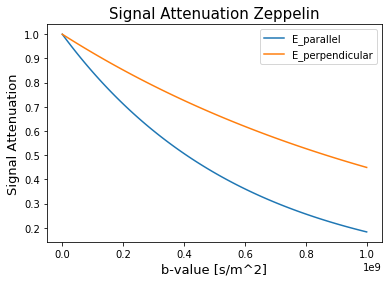

In [2]:
# We set the parallel diffusivity larger than the perpendicular diffusivity
zeppelin = gaussian_models.G2Zeppelin(lambda_par=1.7e-9, lambda_perp=0.8e-9)
E_zeppelin_par = zeppelin(scheme, mu=[0, 0])
E_zeppelin_perp = zeppelin(scheme, mu=[np.pi / 2, 0.])

plt.plot(bvalues, E_zeppelin_par, label='E_parallel')
plt.plot(bvalues, E_zeppelin_perp, label='E_perpendicular')
plt.legend()
plt.xlabel('b-value [s/m^2]', fontsize=13)
plt.ylabel('Signal Attenuation', fontsize=13)
plt.title('Signal Attenuation Zeppelin', fontsize=15);

## Restricted Zeppelin: G3
In DTI, the signal attenuation decays like a Gaussian over q-value and like an expontial over diffusion time $\tau$. 
However, recent works argue that hindered diffusion is actually slower-than-exponential over $\tau$ due to how the external axon boundaries still restrict diffusing particles*(Novikov et al. 2014)*.
To account for this, *(Burcaw et al. 2015)* proposed a modification to the Zeppelin as

\begin{equation}
\textbf{D}_{\textrm{diag}}^{\textrm{r}}=
\begin{pmatrix}
  \lambda_\parallel & 0 & 0  \\
  0 & \lambda_\perp^{\textrm{r}} & 0  \\
  0  & 0  & \lambda_\perp^{\textrm{r}}
 \end{pmatrix}\quad\textrm{with}\quad\lambda_\perp^{\textrm{r}}=D_{\infty}+\frac{A\ln(\Delta/\delta)+3/2}{\Delta-\delta/3}
\end{equation}
where perpendicular diffusivity $\lambda_\perp^{\textrm{r}}$ is now time-dependent with $D_{\infty}$ the bulk diffusion constant and $A$ is a characteristic coefficient for extra-axonal restriction.
Notice that when $A=0$ then G3 simplifies to G2.

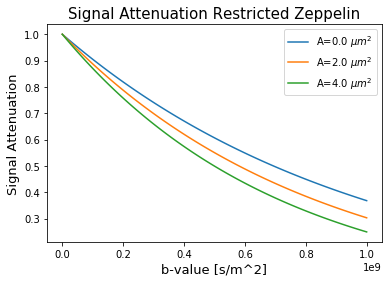

In [3]:
# we just sample the (restricted) perpendicular direction now
restricted_zeppelin = gaussian_models.G3RestrictedZeppelin(mu=[np.pi / 2, 0.], lambda_par=1.7e-9, lambda_inf = 1e-9)

for A in [0, 2e-12, 4e-12]:
    plt.plot(bvalues, restricted_zeppelin(scheme, A=A), label='A={} $\mu m^2$'.format(A*1e12))
plt.legend()
plt.xlabel('b-value [s/m^2]', fontsize=13)
plt.ylabel('Signal Attenuation', fontsize=13)
plt.title('Signal Attenuation Restricted Zeppelin', fontsize=15);

Notice that for larger characteristic coefficients the signal attenuates faster.

## References
- Behrens, Timothy EJ, et al. "Characterization and propagation of uncertainty in diffusion‐weighted MR imaging." Magnetic resonance in medicine 50.5 (2003): 1077-1088. 
- Alexander, Daniel C., et al. "Orientationally invariant indices of axon diameter and density from diffusion MRI." Neuroimage 52.4 (2010): 1374-1389.
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.
- Tariq, Maira, et al. "Bingham–noddi: Mapping anisotropic orientation dispersion of neurites using diffusion mri." NeuroImage 133 (2016): 207-223.
- Panagiotaki, Eleftheria, et al. "Compartment models of the diffusion MR signal in brain white matter: a taxonomy and comparison." Neuroimage 59.3 (2012): 2241-2254.
- Novikov, Dmitry S., et al. "Revealing mesoscopic structural universality with diffusion." Proceedings of the National Academy of Sciences 111.14 (2014): 5088-5093.
- Burcaw, Lauren M., Els Fieremans, and Dmitry S. Novikov. "Mesoscopic structure of neuronal tracts from time-dependent diffusion." NeuroImage 114 (2015): 18-37.